Model definition, training and evaluation

In [1]:
# --- Import libraries ---
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from collections import Counter
from sklearn.preprocessing import label_binarize


In [2]:
# --- Import preprocessing function ---
from data_preprocessing import get_dataloaders

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# --- Load DataLoaders ---
train_loader, val_loader, test_loader = get_dataloaders(
    train_directory = "/path/to/BCI_dataset/HE/train", # insert path to train dataset
    test_directory = "/path/to/BCI_dataset/HE/test", # insert path to test dataset
    batch_size = 32
)
print("DataLoaders loaded successfully!")

DataLoaders loaded successfully!


In [5]:
# --- Determine class distribution in training set ---
training_labels = [label for _, label in train_loader.dataset]
print("Training HER2 expression levels:", Counter(training_labels))

Training HER2 expression levels: Counter({2: 977, 3: 593, 1: 518, 0: 120})


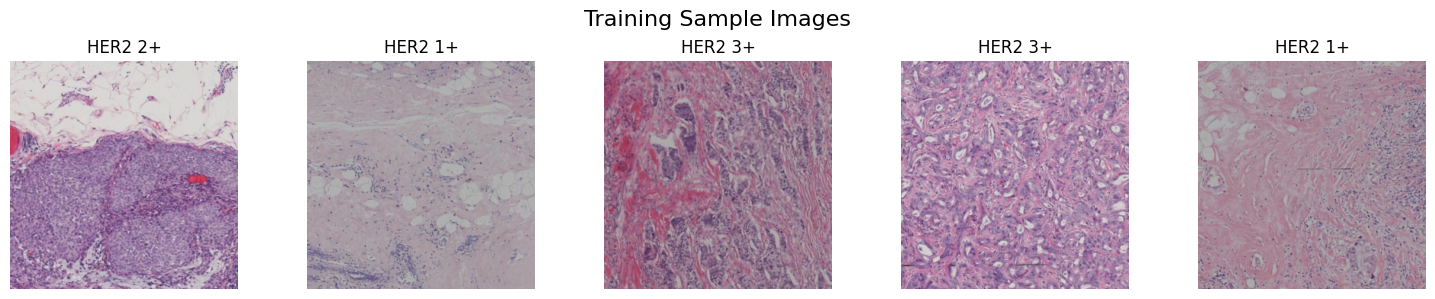

In [6]:
# --- Visualizing Training Sample Images ---

classes = ["HER2 0", "HER2 1+", "HER2 2+", "HER2 3+"]

figure = plt.figure(figsize=(15, 3))
cols, rows = 5, 1
dataset = train_loader.dataset
figure.suptitle("Training Sample Images", fontsize = 16)

for i in range(1, cols * rows + 1): 
    sample_idx = torch.randint(len(dataset), size = (1,)).item() 
    img, label = dataset[sample_idx]
    
    if isinstance(img, torch.Tensor): 
        img = img.permute(1, 2, 0)# converts CxHxW to HxWxC
    
    figure.add_subplot(rows, cols, i) 
    plt.title(classes[label]) 
    plt.axis("off") 
    plt.imshow(img) 
plt.tight_layout(rect = [0, 0, 1, 1])
plt.show()

In [7]:
# --- Create class weights ---
class_counts = Counter(training_labels)

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = torch.tensor([total_samples / (num_classes * class_counts[i]) for i in range (num_classes)], dtype = torch.float32).to(device)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([4.6000, 1.0656, 0.5650, 0.9309], device='cuda:0')


In [8]:
# --- Define Model ---
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, 32, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 48, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace = True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16, 24, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace = True)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, 16, kernel_size = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim = 1)
        return outputs

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.inception = InceptionBlock(in_channels = 3)  

        self.features = nn.Sequential(
            nn.Conv2d(120, 128, kernel_size=3, padding = 1),  # 120 channels from Inception output
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            InceptionBlock(in_channels = 128), 
            
            nn.Conv2d(120, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            InceptionBlock(in_channels = 256),
            
            nn.Conv2d(120, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            InceptionBlock(in_channels = 256),
            
            nn.Conv2d(120, 512, kernel_size = 3, padding = 1), # added another conv - changed input to match new conv
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 1024, kernel_size=3, padding=2), 
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024,512), 
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(512, 256), 
            nn.ReLU(inplace = True),
            nn.Dropout(), 
            nn.Linear(256, 4)  # 4 classes
        )

    def forward(self, x):
        x = self.inception(x)
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
HER2_expression_model = CustomCNN().to(device)
print(HER2_expression_model)

CustomCNN(
  (inception): InceptionBlock(
    (branch1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch3): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch4): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=

In [10]:
# --- Define number of epochs ---
n_epochs = 60 

In [11]:
# --- Train Model ---
HER2_expression_model.train()

optimizer = torch.optim.Adam(HER2_expression_model.parameters(), lr=0.0001, weight_decay = 0.0001)
loss_fn = nn.CrossEntropyLoss(weight = class_weights)

losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = HER2_expression_model(images)
        loss = loss_fn(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Report epochs
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)  # append only one value per epoch
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/60, Loss: 1.2639


Epoch 2/60, Loss: 1.1010


Epoch 3/60, Loss: 1.0815


Epoch 4/60, Loss: 1.0028


Epoch 5/60, Loss: 0.9786


Epoch 6/60, Loss: 0.9486


Epoch 7/60, Loss: 0.9347


Epoch 8/60, Loss: 0.8982


Epoch 9/60, Loss: 0.9060


Epoch 10/60, Loss: 0.8194


Epoch 11/60, Loss: 0.8165


Epoch 12/60, Loss: 0.7795


Epoch 13/60, Loss: 0.7667


Epoch 14/60, Loss: 0.7938


Epoch 15/60, Loss: 0.7291


Epoch 16/60, Loss: 0.7267


Epoch 17/60, Loss: 0.7117


Epoch 18/60, Loss: 0.6697


Epoch 19/60, Loss: 0.6685


Epoch 20/60, Loss: 0.6426


Epoch 21/60, Loss: 0.5997


Epoch 22/60, Loss: 0.6307


Epoch 23/60, Loss: 0.6417


Epoch 24/60, Loss: 0.6170


Epoch 25/60, Loss: 0.5630


Epoch 26/60, Loss: 0.5908


Epoch 27/60, Loss: 0.5237


Epoch 28/60, Loss: 0.5003


Epoch 29/60, Loss: 0.5538


Epoch 30/60, Loss: 0.5212


Epoch 31/60, Loss: 0.4671


Epoch 32/60, Loss: 0.4647


Epoch 33/60, Loss: 0.5004


Epoch 34/60, Loss: 0.4772


Epoch 35/60, Loss: 0.4470


Epoch 36/60, Loss: 0.4380


Epoch 37/60, Loss: 0.4284


Epoch 38/60, Loss: 0.4380


Epoch 39/60, Loss: 0.3904


Epoch 40/60, Loss: 0.3995


Epoch 41/60, Loss: 0.4785


Epoch 42/60, Loss: 0.4148


Epoch 43/60, Loss: 0.3425


Epoch 44/60, Loss: 0.3507


Epoch 45/60, Loss: 0.4267


Epoch 46/60, Loss: 0.3550


Epoch 47/60, Loss: 0.3644


Epoch 48/60, Loss: 0.3226


Epoch 49/60, Loss: 0.3561


Epoch 50/60, Loss: 0.4152


Epoch 51/60, Loss: 0.3430


Epoch 52/60, Loss: 0.4577


Epoch 53/60, Loss: 0.3147


Epoch 54/60, Loss: 0.2870


Epoch 55/60, Loss: 0.3072


Epoch 56/60, Loss: 0.2847


Epoch 57/60, Loss: 0.3322


Epoch 58/60, Loss: 0.2593


Epoch 59/60, Loss: 0.4418


Epoch 60/60, Loss: 0.3233


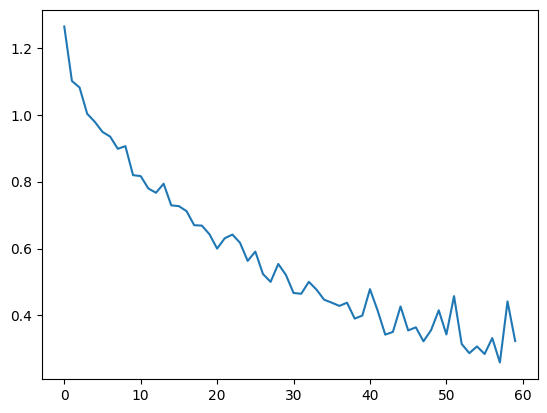

In [12]:
# --- Loss Plot ---
fig, ax = plt.subplots()
ax.plot(losses)

Training Set Evaluation


Accuracy: 0.9012681159420289
Precision (macro): 0.8716574143447371
Recall (macro): 0.9303071171161619


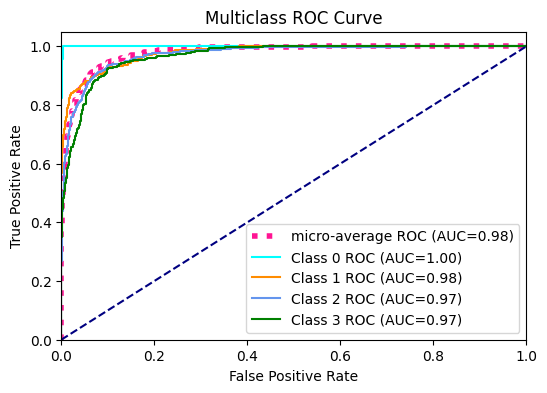


Validation Set Evaluation


Accuracy: 0.8729582577132486
Precision (macro): 0.8346659291299037
Recall (macro): 0.8985305895775563


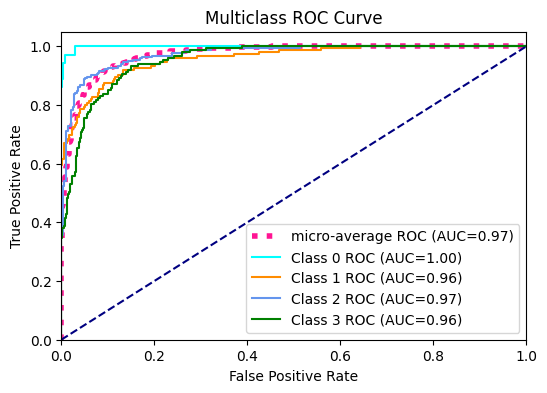

In [13]:
# -- Evaluate Model --
HER2_expression_model.eval()

def evaluate_model(loader, model, num_classes):
    y_true = []
    y_pred = []
    y_prob = []
    
    for images, labels in loader:
        images = images.to(device).float()
        labels = labels.cpu().numpy()
        
        outputs = model(images).cpu().detach().numpy()
        predictions = np.argmax(outputs, axis = 1)
        
        y_true.extend(labels)
        y_pred.extend(predictions)
        y_prob.extend(outputs)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average = "macro"))
    print("Recall (macro):", recall_score(y_true, y_pred, average = "macro"))
    
    # --- ROC-AUC curves ---
    try:
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Micro-average curve ("global" curve that considers all predictions equally)
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC={roc_auc['micro']:.2f})", color="deeppink", linestyle=":", linewidth=4)
        colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, label=f"Class {i} ROC (AUC={roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multiclass ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print("ROC-AUC could not be calculated:", e)

# --- Training Set Evaluation ---
print("Training Set Evaluation")
evaluate_model(train_loader, HER2_expression_model, num_classes = 4)

# --- Validation Set Evaluation ---
print("\nValidation Set Evaluation")
evaluate_model(val_loader, HER2_expression_model, num_classes = 4)
        